In [1]:
import numpy as np 
import pandas as pd

real_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv') 

In [2]:
print(len(real_data))
print(len(fake_data))

# fake데이터와 true데이터의 개수 동일하게 설정
nb_articles = min(len(real_data), len(fake_data))
real_data = real_data[:nb_articles]
fake_data = fake_data[:nb_articles]

print(len(real_data))
print(len(fake_data))

21417
23481
21417
21417


In [3]:
# row에 'is_fake' row 추가하여 값 초기화
real_data['is_fake'] = False
fake_data['is_fake'] = True

In [4]:
real_data.head()

,title,text,subject,date,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",False
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",False
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",False
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",False
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",False


In [5]:
fake_data.head()

,title,text,subject,date,is_fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",True
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",True
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",True
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",True
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",True


In [6]:
from sklearn.utils import shuffle

data = pd.concat([real_data, fake_data])

# fake, true 데이터를 합치고, 무작위 셔플
data = shuffle(data).reset_index(drop=True)
data.head()

,title,text,subject,date,is_fake
0,“YOU ARE FAKE NEWS!” TRUMP DESTROYS CNN Right ...,,politics,"Jan 11, 2017",True
1,Catalonia asks Spain for dialogue as independe...,MADRID (Reuters) - Catalonian leaders on Frida...,worldnews,"September 15, 2017",False
2,Trump says won't wait for negotiations with Me...,NEW YORK (Reuters) - U.S. President-elect Dona...,politicsNews,"January 11, 2017",False
3,ILLEGAL ALIENS Sent To States With Lax Voter I...,DEMOCRATS Making free and fair elections impos...,politics,"May 25, 2016",True
4,China welcomes Myanmars efforts to alleviate s...,BEIJING (Reuters) - China s Foreign Minister W...,worldnews,"September 22, 2017",False


In [7]:
# 학습데이터 60%, 검증데이터 20%, 테스트데이터 20% 로 분리
train_data, validate_data, test_data = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

# reset_index하여 각 데이터별 인덱스 정렬
train_data = train_data.reset_index(drop=True)
validate_data = validate_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

del real_data
del fake_data

print("Size of training set : {}".format(len(train_data)))
print("Size of validation set: {}".format(len(validate_data)))
print("Size of testing set: {}".format(len(test_data)))

Size of training set : 25700
Size of validation set: 8567
Size of testing set: 8567


In [8]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 쿠다없으면 cpu 사용
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
model.config.num_labels = 1

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [9]:
for param in model.parameters():
    param.requires_grad = False

# bert-base의 H=768이기 때문
model.classifier = nn.Sequential(
    nn.Linear(768, 256),
    nn.LeakyReLU(),
    nn.Linear(256,64),
    nn.LeakyReLU(),
    nn.Linear(64, 2),
    nn.Softmax(dim=1)
)
model = model.to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.01)

In [10]:
def preprocess_text(text):
    parts = []

    text_len = len(text.split(' '))
    max_parts = 5
    nb_cuts = int(text_len / 300)
    nb_cuts = min(nb_cuts, max_parts)
    
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * 300: (i + 1) * 300])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

In [11]:
# 모델 학습 주의%%%%%%%%%%오래걸림
print_every = 500
total_loss = 0
all_losses = []
CUDA_LAUNCH_BLOCKING=1
model.train()

for idx, row in train_data.iterrows():
    text_parts = preprocess_text(str(row['text']))
    label = torch.tensor([row['is_fake']]).long().to(device)
    
    optimizer.zero_grad()

    overall_output = torch.zeros((1, 2)).float().to(device)
    for part in text_parts:
        if len(part) > 0:
            try:
                input = part.reshape(-1)[:512].reshape(1, -1)
                # print(input.shape)
                overall_output += model(input, labels=label)[1].float().to(device)
            except Exception as e:
                print(str(e))

    overall_output = F.softmax(overall_output[0], dim=-1)
    
    if label == 0:
        label = torch.tensor([1.0, 0.0]).float().to(device)
    elif label == 1:
        label = torch.tensor([0.0, 1.0]).float().to(device)
        
    #print(overall_output, label)
 
    loss = criterion(overall_output,label)
    total_loss += loss.item()
    
    loss.backward()
    optimizer.step()

    if idx % print_every == 0 and idx > 0:
        average_loss = total_loss / print_every
        print("{}/{}. Average loss: {}".format(idx, len(train_data), average_loss))
        all_losses.append(average_loss)
        total_loss = 0
    

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


500/25700. Average loss: 0.2405767382979393
1000/25700. Average loss: 0.19561399427521975
1500/25700. Average loss: 0.16655264965537936
2000/25700. Average loss: 0.13986783528391972
2500/25700. Average loss: 0.11866451345270616
3000/25700. Average loss: 0.11053659920429346
3500/25700. Average loss: 0.09783518433806784
4000/25700. Average loss: 0.0922685623645648
4500/25700. Average loss: 0.08370011064077698
5000/25700. Average loss: 0.09323939847452857
5500/25700. Average loss: 0.09465336627955913
6000/25700. Average loss: 0.08124276640063181
6500/25700. Average loss: 0.08317646922435233
7000/25700. Average loss: 0.08277861103630857
7500/25700. Average loss: 0.08268898088526384
8000/25700. Average loss: 0.08770587074906507
8500/25700. Average loss: 0.0806950795368175
9000/25700. Average loss: 0.08334949513273023
9500/25700. Average loss: 0.08701412127354342
10000/25700. Average loss: 0.08520468460320262
10500/25700. Average loss: 0.07367725417450674
11000/25700. Average loss: 0.0758447

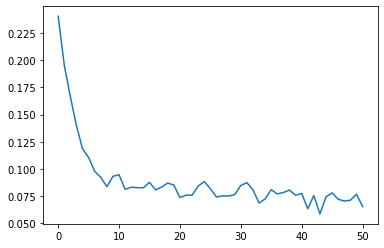

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
#모델 저장
torch.save(model.state_dict(), "final_model.pt")

plt.plot(all_losses)

In [13]:
total = len(test_data)
number_right = 0
model.eval()
# 서버의 메모리를 아끼기 위해
# 예측을 실행하기 전에 그라디언트를 정보를 저장하지 않는다.
# torch.no_grad()
with torch.no_grad():
    for idx, row in test_data.iterrows():
        text_parts = preprocess_text(str(row['text']))
        label = torch.tensor([row['is_fake']]).float().to(device)
        
        overall_output = torch.zeros((1,2)).to(device)
        for part in text_parts:
                if len(part) > 0:
                    overall_output += model(part.reshape(1, -1))[0]
            
        overall_output = F.softmax(overall_output[0], dim=-1)
            
        result = overall_output.max(0)[1].float().item()
        
        # 맞은 개수 count
        if result == label.item():
            number_right += 1
            
        if idx % print_every == 0 and idx > 0:
            print("{}/{}. 현재 정확도: {}".format(idx, total, number_right / idx))
            
print("Accuracy on test data: {}".format(number_right / total))

500/8567. 현재 정확도: 0.97
1000/8567. 현재 정확도: 0.963
1500/8567. 현재 정확도: 0.9633333333333334
2000/8567. 현재 정확도: 0.9655
2500/8567. 현재 정확도: 0.9668
3000/8567. 현재 정확도: 0.968
3500/8567. 현재 정확도: 0.9662857142857143
4000/8567. 현재 정확도: 0.965
4500/8567. 현재 정확도: 0.9642222222222222
5000/8567. 현재 정확도: 0.9634
5500/8567. 현재 정확도: 0.9641818181818181
6000/8567. 현재 정확도: 0.9643333333333334
6500/8567. 현재 정확도: 0.9647692307692308
7000/8567. 현재 정확도: 0.9651428571428572
7500/8567. 현재 정확도: 0.9650666666666666
8000/8567. 현재 정확도: 0.9645
8500/8567. 현재 정확도: 0.9647058823529412
Accuracy on test data: 0.9646317263919691
